In [25]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
diabetes.target[:3]
diabetes.data.shape

(442, 10)

# Classification of the Iris dataset: this is the actual code provided by chatGPT

In [26]:
import numpy as np
from collections import Counter

class DecisionNode:
    """A node in the decision tree."""
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index = feature_index  # index of feature to split on
        self.threshold = threshold          # threshold value for split
        self.left = left                    # left child (DecisionNode)
        self.right = right                  # right child (DecisionNode)
        self.value = value                  # if leaf, the predicted class

def gini(y):
    """Compute Gini impurity for an array of class labels."""
    m = len(y)
    if m == 0:
        return 0.0
    counts = np.bincount(y)
    prob = counts / m
    return 1.0 - np.sum(prob**2)

def best_split(X, y, feature_indices):
    """
    Find the best split (feature, threshold) among the given feature_indices
    by minimizing weighted Gini impurity.
    """
    m, n = X.shape
    best_gini = 1.0
    best_feat, best_thresh = None, None

    for feature in feature_indices:
        # sort data along this feature
        sorted_idx = np.argsort(X[:, feature])
        sorted_vals = X[sorted_idx, feature]
        sorted_y = y[sorted_idx]
        # consider splits between distinct values
        for i in range(1, m):
            if sorted_vals[i] == sorted_vals[i-1]:
                continue
            thresh = (sorted_vals[i] + sorted_vals[i-1]) / 2.0
            left_y = sorted_y[:i]
            right_y = sorted_y[i:]
            g_left = gini(left_y)
            g_right = gini(right_y)
            g_total = (i * g_left + (m - i) * g_right) / m
            if g_total < best_gini:
                best_gini = g_total
                best_feat = feature
                best_thresh = thresh

    return best_feat, best_thresh

def build_tree(X, y, max_features, rng):
    """
    Recursively build a CART tree:
    - Stop and make a leaf if all y are the same class.
    - Otherwise, pick F = max_features at random, find best split, and recurse.
    """
    # Leaf if pure
    if len(set(y)) == 1:
        return DecisionNode(value=y[0])

    n_samples, n_features = X.shape
    # Random subset of features
    feat_idxs = rng.choice(n_features, max_features, replace=False)
    feat, thresh = best_split(X, y, feat_idxs)

    # If no valid split was found, make leaf with majority class
    if feat is None:
        majority = Counter(y).most_common(1)[0][0]
        return DecisionNode(value=majority)

    # Partition data
    left_mask = X[:, feat] < thresh
    right_mask = ~left_mask

    left = build_tree(X[left_mask],  y[left_mask],  max_features, rng)
    right = build_tree(X[right_mask], y[right_mask], max_features, rng)
    return DecisionNode(feature_index=feat, threshold=thresh, left=left, right=right)

class RandomForestGPT:
    """A Random Forest ensemble of CART trees with bootstrap and random feature selection."""
    def __init__(self, n_estimators=100, max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.trees = []
        self.rng = np.random.RandomState(random_state)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        if self.max_features is None:
            # F = floor(log2(M) + 1)
            self.max_features = int(np.log2(n_features) + 1)
        for _ in range(self.n_estimators):
            # Bootstrap sample
            idxs = self.rng.choice(n_samples, n_samples, replace=True)
            Xb, yb = X[idxs], y[idxs]
            tree = build_tree(Xb, yb, self.max_features, self.rng)
            self.trees.append(tree)

    def _predict_tree(self, x, tree):
        node = tree
        while node.value is None:
            if x[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def predict(self, X):
        # Collect each tree's predictions
        preds = np.array([[self._predict_tree(x, t) for t in self.trees] for x in X])
        # Majority vote
        return np.array([Counter(row).most_common(1)[0][0] for row in preds])

def rf_gpt(X, y, n_estimators=100, max_features=None, random_state=None):
    """
    Build and return a RandomForestGPT model fitted to (X, y).

    Parameters
    ----------
    X : array‐like, shape (n_samples, n_features)
    y : array‐like, shape (n_samples,)
    n_estimators : int, default=100
        Number of trees in the forest.
    max_features : int or None, default=None
        Number F of features to consider at each split. If None, set to floor(log2(n_features)+1).
    random_state : int or None
        Seed for reproducibility.

    Returns
    -------
    model : RandomForestGPT
        A fitted RandomForestGPT instance with `.predict(X_new)` available.
    """
    model = RandomForestGPT(n_estimators=n_estimators,
                            max_features=max_features,
                            random_state=random_state)
    model.fit(np.array(X), np.array(y))
    return model

# Example usage on iris:
if __name__ == "__main__":
    from sklearn.datasets import load_iris
    from sklearn.model_selection import train_test_split
    data = load_iris()
    X_train, X_test, y_train, y_test = train_test_split(
        data.data, data.target, test_size=0.3, random_state=42
    )
    rf = rf_gpt(X_train, y_train, n_estimators=50, random_state=42)
    preds = rf.predict(X_test)
    acc = np.mean(preds == y_test)
    print(f"Iris test accuracy: {acc:.3f}")


Iris test accuracy: 1.000


## this is the version provided by Gemini

In [27]:
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Helper function to calculate Gini impurity
def gini_impurity(y):
    """
    Calculates the Gini impurity of a set of labels.
    Gini impurity is a measure of how often a randomly chosen element
    from the set would be incorrectly labeled if it was randomly labeled
    according to the distribution of labels in the subset.
    Gini = 1 - sum(p_i^2) for all classes i.
    """
    n_samples = len(y)
    # Gini impurity is 0 if the node is empty or pure
    if n_samples <= 1:
        return 0

    # Count the occurrences of each class
    hist = np.bincount(y)
    ps = hist / n_samples
    return 1 - np.sum([p**2 for p in ps])

class Node:
    """
    Represents a single node in a decision tree.
    Each node holds the information needed for a split (feature and threshold)
    or the final classification label if it is a leaf node.
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        """Checks if the node is a leaf node."""
        return self.value is not None

class DecisionTree:
    """
    A single decision tree classifier.
    This implementation follows the CART (Classification and Regression Trees)
    methodology mentioned in the paper, using Gini impurity as the splitting criterion.
    The tree is grown to its maximum size and is not pruned.
    """
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        # n_features corresponds to 'F' in the paper: the size of the random
        # subset of features to consider at each split.
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        """Builds the decision tree."""
        # If n_features is not specified, it defaults to the total number of features.
        # For the Random Forest, this will be a smaller subset.
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        """
        Recursively grows the decision tree. This corresponds to the paper's
        instruction to "grow the tree to maximum size and do not prune."
        """
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria for recursion (base cases)
        # 1. Max depth is reached
        # 2. No more splits are possible (all samples are of the same class)
        # 3. Not enough samples to split
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Select a random subset of features to consider for the split.
        # This is the core idea of the "random input selection" (Forest-RI) method.
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the best split (feature and threshold)
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # If a split with positive gain was found, create child nodes
        if best_feature is not None:
            left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
            left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
            right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
            return Node(best_feature, best_thresh, left, right)

        # If no split improves information gain, create a leaf node
        leaf_value = self._most_common_label(y)
        return Node(value=leaf_value)

    def _best_split(self, X, y, feat_idxs):
        """
        Finds the best split by iterating through the random subset of features
        and their unique values (thresholds).
        """
        best_gain = 0 # We only want to split if the gain is positive.
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # Calculate the information gain for the split
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        """
        Calculates the information gain of a split.
        Gain = Gini(parent) - [weighted average of Gini(children)]
        """
        # Gini of the parent node
        parent_gini = gini_impurity(y)

        # Create children based on the threshold
        left_idxs, right_idxs = self._split(X_column, threshold)

        # If a split doesn't produce two children, gain is 0.
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # Calculate the weighted average of the children's Gini impurity
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        g_l, g_r = gini_impurity(y[left_idxs]), gini_impurity(y[right_idxs])
        child_gini = (n_l / n) * g_l + (n_r / n) * g_r

        # Information gain is the reduction in impurity
        ig = parent_gini - child_gini
        return ig

    def _split(self, X_column, split_thresh):
        """Splits a column of data into two children based on a threshold."""
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        """Finds the most common label in a set of labels."""
        # Ensure y is not empty before finding the most common label
        if len(y) == 0:
            return None # Should not happen with the corrected logic, but as a safeguard.
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        """Predicts labels for a set of samples."""
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        """Traverses the tree to predict a label for a single sample."""
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

class RandomForest:
    """
    Random Forest classifier.
    As described in the paper, this is a collection of tree-structured classifiers.
    It uses bagging and the random input selection method (Forest-RI).
    """
    def __init__(self, n_trees=100, n_features=None, min_samples_split=2, max_depth=100):
        self.n_trees = n_trees
        self.n_features = n_features
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        """
        Trains the Random Forest by growing an ensemble of decision trees.
        """
        self.trees = []
        for _ in range(self.n_trees):
            # Create a bootstrap sample of the data (bagging).
            # As per Section 3.1: "Each new training set is drawn, with replacement,
            # from the original training set."
            X_sample, y_sample = self._bootstrap_sample(X, y)

            # Initialize a decision tree with the specified number of random features.
            # The paper suggests F=int(log2(M)+1) as a good value.
            # We calculate this once and reuse it.
            if self.n_features is None:
                M = X.shape[1]
                # Ensure at least one feature is selected
                self.n_features = max(1, int(np.log2(M) + 1))

            tree = DecisionTree(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                n_features=self.n_features
            )
            # Grow the tree on the bootstrapped sample.
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y):
        """Creates a bootstrap sample of the dataset."""
        n_samples = X.shape[0]
        # Draw n_samples with replacement
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        """Finds the most common label in a set of labels."""
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        """
        Makes predictions by aggregating the votes from each tree in the forest.
        As per Definition 1.1: "...each tree casts a unit vote for the most
        popular class at input x."
        """
        # Get predictions from all trees in the forest
        predictions = np.array([tree.predict(X) for tree in self.trees])
        # Transpose so each row corresponds to a sample and each column to a tree
        tree_preds = np.swapaxes(predictions, 0, 1)
        # For each sample, find the most common prediction (majority vote)
        y_pred = [self._most_common_label(preds) for preds in tree_preds]
        return np.array(y_pred)

if __name__ == '__main__':
    # --- Testing the implementation with the Iris dataset ---
    print("--- Random Forest Classifier from Breiman's Paper ---")

    # Load the dataset
    data = datasets.load_iris()
    X, y = data.data, data.target

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1234
    )

    # Instantiate the RandomForest classifier
    # We use n_features=int(log2(M)+1) as suggested in the paper.
    # For Iris, M=4, so n_features = int(log2(4)+1) = 3.
    clf = RandomForest(n_trees=100)

    # Train the classifier
    print("\nTraining the forest...")
    clf.fit(X_train, y_train)
    print("Training complete.")

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    def accuracy(y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

    acc = accuracy(y_test, y_pred)
    print(f"\nRandom Forest classification accuracy on Iris test set: {acc:.4f}")

    # --- Verification of Predictions ---
    print("\nSample Predictions:")
    print("-------------------")
    for i in range(min(5, len(X_test))):
        true_label = data.target_names[y_test[i]]
        pred_label = data.target_names[y_pred[i]]
        print(f"Sample {i+1}: True='{true_label}', Predicted='{pred_label}'")
    print("-------------------\n")


--- Random Forest Classifier from Breiman's Paper ---

Training the forest...
Training complete.

Random Forest classification accuracy on Iris test set: 1.0000

Sample Predictions:
-------------------
Sample 1: True='versicolor', Predicted='versicolor'
Sample 2: True='versicolor', Predicted='versicolor'
Sample 3: True='virginica', Predicted='virginica'
Sample 4: True='setosa', Predicted='setosa'
Sample 5: True='versicolor', Predicted='versicolor'
-------------------



In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ---- Load data ----
iris = datasets.load_iris()
X, y = iris.data, iris.target

# ---- Run 100 Trials and Plot ----
n_trials    = 100
acc_gpt     = []    # custom RF
acc_sklearn = []
acc_gemini  = []    # Gemini RF

for i in range(n_trials):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=i
    )

    # Custom RF (GPT version)
    rf_gpt = RandomForestGPT(
        n_estimators=10,
        max_features=int(np.sqrt(X.shape[1])),
        random_state=i
    )
    rf_gpt.fit(X_train, y_train)
    y_pred_gpt = rf_gpt.predict(X_test)
    acc_gpt.append(np.mean(y_pred_gpt == y_test))

    # sklearn RF
    rf_sk = RandomForestClassifier(
        n_estimators=10,
        max_features="sqrt",
        random_state=i
    )
    rf_sk.fit(X_train, y_train)
    y_pred_sk = rf_sk.predict(X_test)
    acc_sklearn.append(np.mean(y_pred_sk == y_test))

    # Gemini RF
    rf_gem = RandomForest(
        n_trees=10,
        n_features=int(np.sqrt(X.shape[1]))
    )
    rf_gem.fit(X_train, y_train)
    y_pred_gem = rf_gem.predict(X_test)
    acc_gemini.append(np.mean(y_pred_gem == y_test))



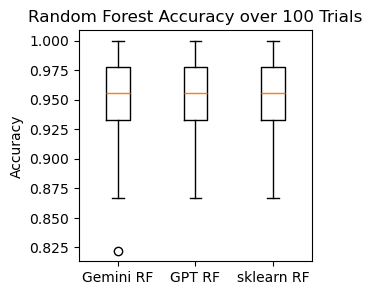

In [29]:
## for the paper
plt.rcParams['figure.figsize'] = 3,3
plt.boxplot([acc_gemini, acc_gpt, acc_sklearn], labels=["Gemini RF", "GPT RF", "sklearn RF"])
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy over 100 Trials")
plt.savefig('../plots/RF-accuracy-3models.svg', bbox_inches='tight')
plt.show()


# Regression version of RF applied to the diabetes dataset: this is the exact code generated by chatGPT

Completed 10/100 trials
Completed 20/100 trials
Completed 30/100 trials
Completed 40/100 trials
Completed 50/100 trials
Completed 60/100 trials
Completed 70/100 trials
Completed 80/100 trials
Completed 90/100 trials
Completed 100/100 trials


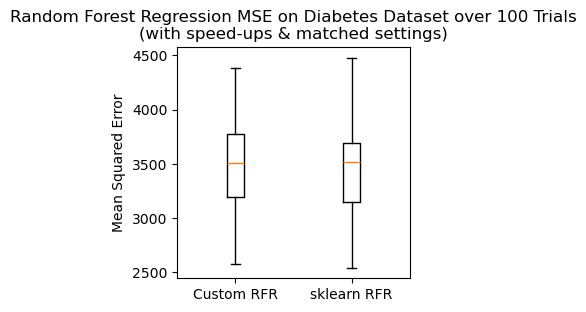

In [30]:
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# ---- Utility functions for regression trees ----
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    return X[indices], y[indices]

def variance(y):
    return np.var(y) if len(y) > 0 else 0.0

def mean_value(y):
    return np.mean(y) if len(y) > 0 else 0.0

def split_dataset(X, y, feature_idx, threshold):
    left_mask = X[:, feature_idx] <= threshold
    return X[left_mask], y[left_mask], X[~left_mask], y[~left_mask]

def best_split_regression(X, y, feature_indices, n_thresholds=10):
    best_gain = 0
    best_feat, best_thresh = None, None
    parent_var = variance(y)
    n = len(y)
    for feat in feature_indices:
        unique_vals = np.unique(X[:, feat])
        # subsample thresholds if too many
        if len(unique_vals) > n_thresholds:
            thresholds = np.random.choice(unique_vals, size=n_thresholds, replace=False)
        else:
            thresholds = unique_vals
        for t in thresholds:
            Xl, yl, Xr, yr = split_dataset(X, y, feat, t)
            if len(yl) < 1 or len(yr) < 1:
                continue
            p = len(yl) / n
            gain = parent_var - (p * variance(yl) + (1 - p) * variance(yr))
            if gain > best_gain:
                best_gain = gain
                best_feat, best_thresh = feat, t
    return best_feat, best_thresh

# ---- Decision Tree Regressor ----
class DecisionTreeRegressorScratch:
    def __init__(self, max_features=None, min_samples_split=10, thresholds_per_feature=10):
        self.max_features = max_features
        self.min_samples_split = min_samples_split
        self.thresholds_per_feature = thresholds_per_feature

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y):
        # stopping criteria
        if len(y) < self.min_samples_split or variance(y) == 0:
            return {'type': 'leaf', 'value': mean_value(y)}
        feat_idxs = np.random.choice(
            self.n_features,
            self.max_features or self.n_features,
            replace=False
        )
        feat, thresh = best_split_regression(X, y, feat_idxs, self.thresholds_per_feature)
        if feat is None:
            return {'type': 'leaf', 'value': mean_value(y)}
        Xl, yl, Xr, yr = split_dataset(X, y, feat, thresh)
        left = self._build_tree(Xl, yl)
        right = self._build_tree(Xr, yr)
        return {
            'type': 'node',
            'feature': feat,
            'threshold': thresh,
            'left': left,
            'right': right
        }

    def _predict_one(self, x, node):
        if node['type'] == 'leaf':
            return node['value']
        if x[node['feature']] <= node['threshold']:
            return self._predict_one(x, node['left'])
        else:
            return self._predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

# ---- Random Forest Regressor ----
class RandomForestRegressorScratch:
    def __init__(self, n_trees=10, max_features=None, min_samples_split=10, thresholds_per_feature=10):
        self.n_trees = n_trees
        self.max_features = max_features
        self.min_samples_split = min_samples_split
        self.thresholds_per_feature = thresholds_per_feature

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            X_s, y_s = bootstrap_sample(X, y)
            tree = DecisionTreeRegressorScratch(
                max_features=self.max_features,
                min_samples_split=self.min_samples_split,
                thresholds_per_feature=self.thresholds_per_feature
            )
            tree.fit(X_s, y_s)
            self.trees.append(tree)

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(preds, axis=0)

# ---- Demonstration on the diabetes dataset ----
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

n_trials = 100
mse_custom = []
mse_sklearn = []

for i in range(n_trials):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=i
    )

    # Custom RF regressor with speed-ups
    rfr_custom = RandomForestRegressorScratch(
        n_trees=10,
        max_features=int(np.sqrt(X.shape[1])),
        min_samples_split=10,
        thresholds_per_feature=10
    )
    rfr_custom.fit(X_train, y_train)
    y_pred_custom = rfr_custom.predict(X_test)
    mse_custom.append(np.mean((y_pred_custom - y_test)**2))

    # sklearn RF regressor with matching settings
    rfr_sk = RandomForestRegressor(
        n_estimators=10,
        max_features="sqrt",
        min_samples_split=10,
        random_state=i
    )
    rfr_sk.fit(X_train, y_train)
    y_pred_sk = rfr_sk.predict(X_test)
    mse_sklearn.append(np.mean((y_pred_sk - y_test)**2))

    # Progress update every 10 trials
    if (i + 1) % 10 == 0:
        print(f"Completed {i + 1}/{n_trials} trials")
        
# ---- Boxplot of MSE ----
plt.boxplot([mse_custom, mse_sklearn])
plt.xticks([1, 2], ["Custom RFR", "sklearn RFR"])
plt.ylabel("Mean Squared Error")
plt.title("Random Forest Regression MSE on Diabetes Dataset over 100 Trials\n(with speed-ups & matched settings)")
plt.show()


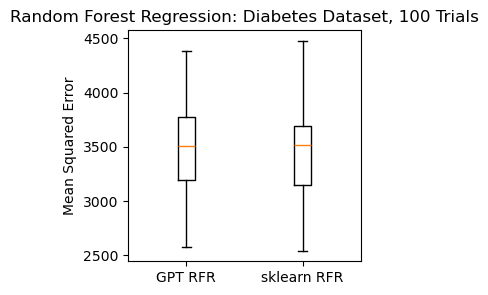

In [31]:
# ---- Boxplot of MSE ----
plt.rcParams['figure.figsize']=3,3
plt.boxplot([mse_custom, mse_sklearn])
plt.xticks([1, 2], ["GPT RFR", "sklearn RFR"])
plt.ylabel("Mean Squared Error")
plt.title("Random Forest Regression: Diabetes Dataset, 100 Trials")
plt.savefig('../plots/diabetes.svg', bbox_inches='tight')
plt.show()
